In [431]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tableone import TableOne
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from keras.layers import Dense, LSTM, Bidirectional, Dropout
from keras.models import Sequential
import tensorflow as tf


Functions that modify the Datasets

In [451]:
def impute_missing(data_sensors, column):
    before_imputation = data_sensors.copy()

    for index, row in data_sensors.iterrows():
        if pd.isna(row[column]):
            #prev row
            prev = data_sensors.loc[:index].loc[~data_sensors[column].isna()].tail(1)
            #next row
            next = data_sensors.loc[index:].loc[~data_sensors[column].isna()].head(1)

            if not (prev.empty or next.empty):
                mean = round((prev[column].values[0] + next[column].values[0]) / 2, 2)
                data_sensors.at[index, column] = mean

    
    changes = pd.DataFrame(columns=['Index', 'before', 'after'])
    for index, row in before_imputation.iterrows():
        before = row[column]
        after = data_sensors.at[index, column]
        if pd.notna(before) and pd.notna(after) and before != after:
            changes = changes.append({'Index': index, 'before': before, 'after': after}, ignore_index=True)

    return data_sensors, changes

def rename_sensor(data_sensors):

    sensor_ids = ['am3019-testqc2090', 'am307-9074', 'eui-24e124128c147204',
                  'eui-24e124128c147444', 'eui-24e124128c147446',
                  'eui-24e124128c147470', 'eui-24e124128c147499',
                  'eui-24e124128c147500', 'eui-24e124710c408089',
                  'eui-24e124725c461468', 'q4-1003-7456']
    #We will not use Biblio_Filo and AudioLab Data
    sensors_names = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']
    
    mapp = dict(zip(sensor_ids, sensors_names))
    data_sensors['location'] = data_sensors['location'].map(mapp).fillna(data_sensors['location'])
    
    data_sensors = data_sensors[(data_sensors['location'] != 'Biblio_Filo') & (data_sensors['location'] != 'AudioLab')]
    
    return data_sensors

def get_season(month):
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def get_time_of_day(hour):
    hour = int(hour)
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'
    
def combine_dataframes(sensor_name,data_meteo):
    data_meteo['DateTime'] = pd.to_datetime(data_meteo['Date'] + ' ' + data_meteo['Hour'])
    
    sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])

    #round the hours to the nearest multiple of 30 minutes
    sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')

    #combine Dataframes by datetime column
    combined = pd.merge(sensor_name, data_meteo, on='DateTime', how='inner')
    combined = combined.drop(columns=["DateTime","Date_y", "Hour_y", "location"])

    combined.rename(columns={'Date_x': 'Date'}, inplace=True)
    combined.rename(columns={'Hour_x': 'Hour'}, inplace=True)
    combined.rename(columns={'TM': 'TM_outdoor'}, inplace=True)
    combined.rename(columns={'HRM%': 'HRM%_outdoor'}, inplace=True)
    combined.rename(columns={'PPT': 'PPT_outdoor'}, inplace=True)
    combined.rename(columns={'RS': 'RS_outdoor'}, inplace=True)
    combined[['Hour', 'Minutes']] = combined['Hour'].str.split(':', expand=True)
    
    #combined['Minutes'] = combined['Minutes'].astype(int)
    combined[['Day', 'Month', 'Year']] = combined['Date'].str.split('-', expand=True)
    #combined['Day'] = combined['Day'].astype(int)
    #combined['Year'] = combined['Year'].astype(int)
    
    #....................................................................
    #Let's create more columns to identify the seasons and time of day
    combined['Season'] = combined['Month'].apply(get_season)
    combined['Time_of_Day'] = combined['Hour'].apply(get_time_of_day)
    
    #OrdinalEncoder - convert categorical data in numerical
    encoder = OrdinalEncoder()
    combined[['Season', 'Time_of_Day']] = encoder.fit_transform(combined[['Season', 'Time_of_Day']])

    #....................................................................
    #We have to divide the ones that have the illumination column and the ones that have light_level
    if 'light_level' in combined.columns:
        combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day','light_level' ,'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]
    elif 'illumination' in combined.columns:
        combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day','illumination' ,'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]
    
    #....................................................................
    #combined = combined[['Day', 'Month','Year', "Season", 'Hour', 'Minutes','Time_of_Day', 'co2', 'humidity', 'o3', 'pressure', 'temperature', 'tvoc', 'TM_outdoor', 'HRM%_outdoor', 'PPT_outdoor', 'RS_outdoor']]

    return combined


Functions to plot

In [460]:
def display_plot(data,x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();


def display_outliers(sensor_com):
    sensor_com = sensor_com.drop('light_level', axis=1)
    num_feats = [col for col in sensor_com.columns if sensor_com[col].dtype != 'object']

    fig, axes = plt.subplots(nrows=len(num_feats)//2, ncols=2, figsize=(16, 8 * (len(num_feats)//2)))
    axes = axes.flatten()

    #iterate over numerical features
    for i, col in enumerate(num_feats):
        #boxplot for each feature
        sb.boxplot(x=sensor_com[col], color='red', ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()

We have loaded the dataframes and modified the formats so that they are similar

In [434]:
data_meteo = pd.read_excel("C:/Users/migue/UAB_EnergyStudy/DataSets_/Meteo - Sensors Data/datos_meteo.xlsx")

data_meteo['Hora'] = data_meteo['Hora'].str.split(' - ').str[0]
data_meteo = data_meteo.rename(columns={'Fecha': 'Date'})
data_meteo = data_meteo.rename(columns={'Hora': 'Hour'})

In [435]:
data_sensors = pd.read_csv("C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv")


data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')
data_sensors = data_sensors.drop(columns=['_measurement'])

In [436]:
data_sensors.shape

(1745335, 5)

We have created the columns based on the _field data to have the dataset more compressed, ordered and with more columns

In [437]:
data_sensors = data_sensors.pivot_table(index=['location', 'Date', 'Hour'], columns='_field', values='_value')
data_sensors = data_sensors.reset_index()
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%d-%m-%Y')
data_sensors = data_sensors.sort_values(by=['location', 'Date', 'Hour'])
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

data_sensors = data_sensors.drop(columns=["activity","battery","infrared_and_visible", "pm10", "pm2_5", "infrared"])

In [438]:
data_sensors = rename_sensor(data_sensors)

In [439]:
data_sensors.shape

(193215, 11)

Missing Values

In [440]:
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())
print(data_meteo[data_meteo.columns[data_meteo.isnull().sum()>0]].isnull().sum())

_field
co2                616
humidity           798
illumination    127809
light_level      97889
o3              129341
pressure         32485
temperature        801
tvoc             32307
dtype: int64
Series([], dtype: float64)


In [441]:
"""#tarda como 25 min
data_sensors, _ = impute_missing(data_sensors, "temperature")
data_sensors, _ = impute_missing(data_sensors, "humidity")
data_sensors, _ = impute_missing(data_sensors, "co2") 
data_sensors, _ = impute_missing(data_sensors, "pressure")
data_sensors, _ = impute_missing(data_sensors, "tvoc")"""

In [442]:
#data_sensors.fillna(0, inplace=True)
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())

_field
illumination    127809
light_level      97889
o3              129341
dtype: int64


Duplicates

In [443]:
data_sensors.duplicated().sum()

0

In [444]:
data_sensors.describe()

_field,co2,humidity,illumination,light_level,o3,pressure,temperature,tvoc
count,193215.000000,193215.000000,65406.000000,95326.000000,63874.000000,193215.000000,193215.000000,193215.000000
mean,565.605978,46.974533,47.988411,0.442524,0.135181,998.801031,22.834601,142.759276
std,254.628069,11.026851,146.762209,0.914324,0.072241,9.485028,3.990670,175.868772
min,355.000000,20.500000,0.000000,0.000000,0.020000,960.500000,10.800000,0.000000
25%,445.000000,38.500000,1.000000,0.000000,0.060000,993.500000,20.200000,88.000000
50%,476.000000,46.500000,1.000000,0.000000,0.090000,1001.100000,22.700000,100.000000
75%,562.000000,56.000000,9.000000,1.000000,0.210000,1003.900000,25.300000,153.000000
max,3743.000000,77.000000,1365.000000,4.000000,0.260000,1025.400000,36.500000,9738.000000


Minutes Round

In [445]:
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format='%H:%M')
data_sensors['Hour'] = data_sensors['Hour'].apply(lambda x: datetime.strptime(x.strftime('%H:%M'), '%H:%M').replace(minute=(x.minute // 10) * 10))
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')

In [446]:
data_sensors.to_csv("data_sensors_v1.csv",index=False)  

# Recommender System

In [447]:
data_meteo

,Date,Hour,TM,HRM%,PPT,RS
0,25-07-2023,00:00,24.7,73,0.0,0
1,25-07-2023,00:30,24.4,74,0.0,0
2,25-07-2023,01:00,24.1,75,0.0,0
3,25-07-2023,01:30,23.9,75,0.0,0
4,25-07-2023,02:00,23.9,74,0.0,0
...,...,...,...,...,...,...
11995,30-03-2024,21:30,11.9,89,0.0,0
11996,30-03-2024,22:00,12.0,87,0.0,0
11997,30-03-2024,22:30,12.2,88,0.5,0
11998,30-03-2024,23:00,12.7,86,0.0,0


In [448]:
data_sensors = pd.read_csv("data_sensors_v1.csv")
data_sensors

,location,Date,Hour,co2,humidity,illumination,light_level,o3,pressure,temperature,tvoc
0,testqc2090,25-07-2023,13:50,472.0,36.0,NaN,1.0,0.05,996.9,27.8,100.0
1,testqc2090,25-07-2023,14:00,466.0,36.0,NaN,1.0,0.05,996.9,27.9,100.0
2,testqc2090,25-07-2023,14:10,466.0,36.0,NaN,1.0,0.05,996.9,27.9,100.0
3,testqc2090,25-07-2023,14:20,455.0,36.0,NaN,1.0,0.05,996.8,27.9,100.0
4,testqc2090,25-07-2023,14:30,463.0,36.0,NaN,1.0,0.05,996.7,28.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...
193210,Classroom,30-03-2024,11:40,438.0,39.0,11.0,NaN,NaN,976.1,22.0,173.0
193211,Classroom,30-03-2024,11:50,427.0,38.5,9.0,NaN,NaN,976.2,22.3,180.0
193212,Classroom,30-03-2024,12:00,433.0,38.0,7.0,NaN,NaN,976.2,22.5,183.0
193213,Classroom,30-03-2024,12:10,426.0,38.0,9.0,NaN,NaN,976.2,22.7,184.0


In [449]:
data_sensors['location'].unique()

array(['testqc2090', 'Computer_Room', 'Digital_Lab', '24e124128c147446',
       '24e124128c147470', 'OpenLab_Main_Room', 'OpenLab_Laser_Room',
       '24e124725c461468', 'Classroom'], dtype=object)

In [450]:
testqc2090 = data_sensors[data_sensors['location'] == 'testqc2090']
Computer_Room = data_sensors[data_sensors['location'] == 'Computer_Room']
Digital_Lab = data_sensors[data_sensors['location'] == 'Digital_Lab']
c147446 = data_sensors[data_sensors['location'] == '24e124128c147446']
c147470 = data_sensors[data_sensors['location'] == '24e124128c147470']
OpenLab_Main_Room = data_sensors[data_sensors['location'] == 'OpenLab_Main_Room']
OpenLab_Laser_Room = data_sensors[data_sensors['location'] == 'OpenLab_Laser_Room']
c461468 = data_sensors[data_sensors['location'] == '24e124725c461468']
Classroom = data_sensors[data_sensors['location'] == 'Classroom']

We combine the two datasets to have only one (for date and time and for each sensor)

In [452]:
testqc2090_com = combine_dataframes(testqc2090,data_meteo)
Computer_Room_com = combine_dataframes(Computer_Room,data_meteo)
Digital_Lab_com = combine_dataframes(Digital_Lab,data_meteo)
c147446_com = combine_dataframes(c147446,data_meteo)
c147470_com = combine_dataframes(c147470,data_meteo)
OpenLab_Main_Room_com = combine_dataframes(OpenLab_Main_Room,data_meteo)
OpenLab_Laser_Room_com = combine_dataframes(OpenLab_Laser_Room,data_meteo)
c461468_com = combine_dataframes(c461468,data_meteo)
Classroom_com = combine_dataframes(Classroom,data_meteo)

C:\Users\migue\AppData\Local\Temp\ipykernel_27644\2267462829.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = pd.to_datetime(sensor_name['Date'] + ' ' + sensor_name['Hour'])
C:\Users\migue\AppData\Local\Temp\ipykernel_27644\2267462829.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_name['DateTime'] = sensor_name['DateTime'].dt.round('30min')
C:\Users\migue\AppData\Local\Temp\ipykernel_27644\2267462829.py:71: SettingWithCopyWarning: 
A value is trying to be set on a 

In [453]:
Computer_Room_com

,Day,Month,Year,Season,Hour,Minutes,Time_of_Day,light_level,co2,humidity,o3,pressure,temperature,tvoc,TM_outdoor,HRM%_outdoor,PPT_outdoor,RS_outdoor
0,25,07,2023,2.0,13,50,0.0,1.0,431.0,37.0,NaN,997.6,27.4,100.0,31.0,25,0.0,808
1,25,07,2023,2.0,14,00,0.0,1.0,426.0,37.0,NaN,997.5,27.5,100.0,31.0,25,0.0,808
2,25,07,2023,2.0,14,10,0.0,1.0,438.0,37.0,NaN,997.6,27.5,100.0,31.0,25,0.0,808
3,25,07,2023,2.0,14,20,0.0,1.0,425.0,37.0,NaN,997.6,27.5,100.0,31.2,25,0.0,746
4,25,07,2023,2.0,14,30,0.0,1.0,442.0,36.5,NaN,997.5,27.6,100.0,31.2,25,0.0,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,03,2024,1.0,11,40,2.0,0.0,405.0,38.0,NaN,985.0,22.2,100.0,15.4,44,0.0,340
31485,30,03,2024,1.0,11,50,2.0,0.0,399.0,37.5,NaN,985.1,22.4,100.0,15.0,47,0.0,340
31486,30,03,2024,1.0,12,00,0.0,0.0,403.0,37.0,NaN,985.1,22.6,100.0,15.0,47,0.0,340
31487,30,03,2024,1.0,12,10,0.0,0.0,398.0,36.5,NaN,985.2,22.8,100.0,15.0,47,0.0,340


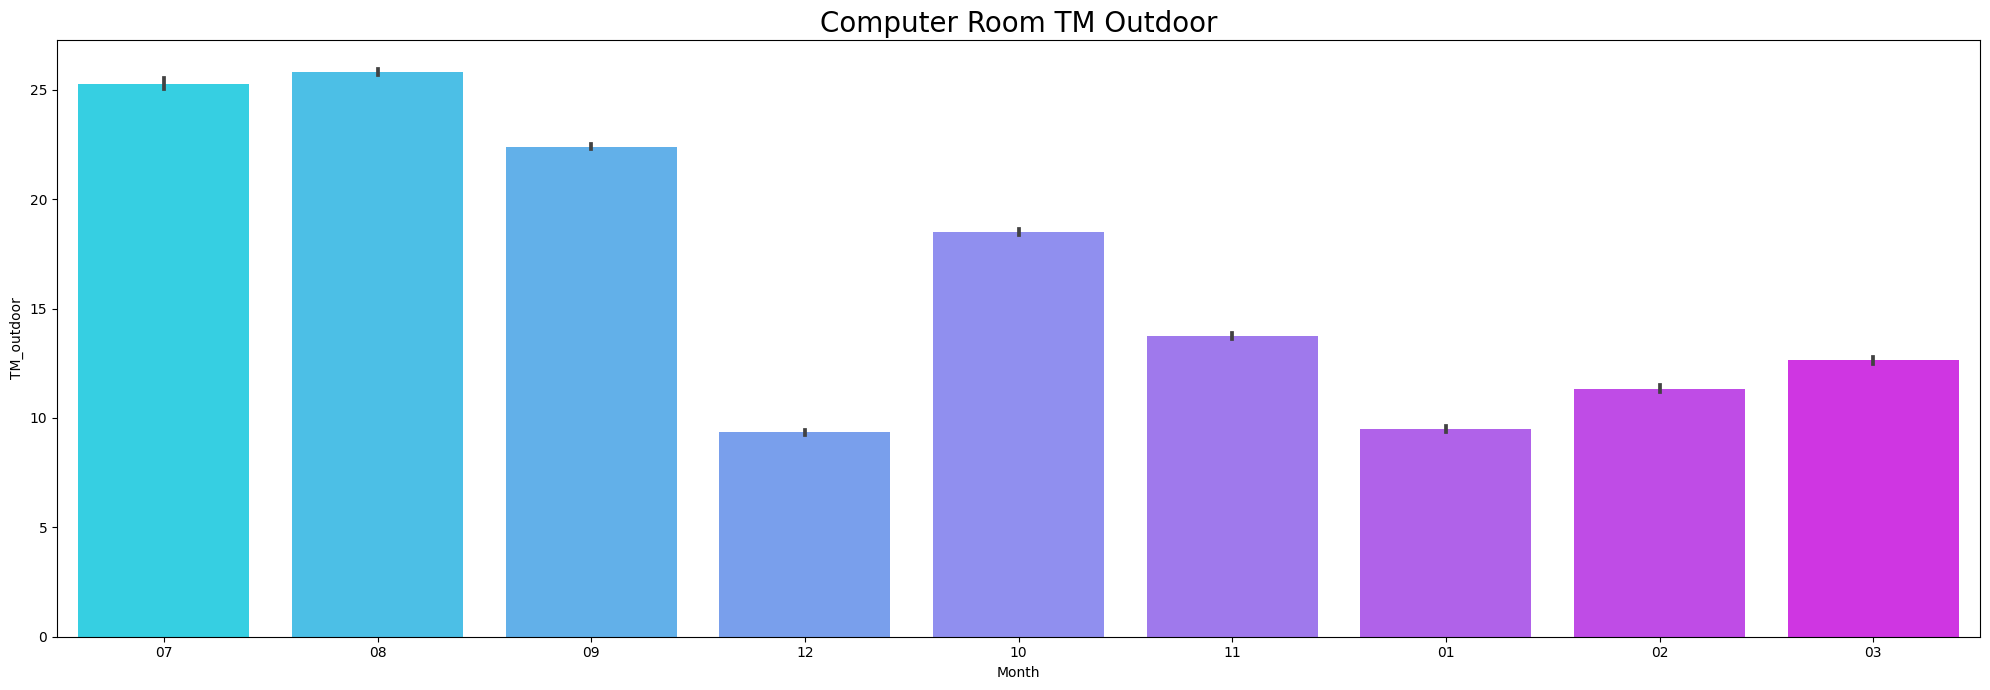

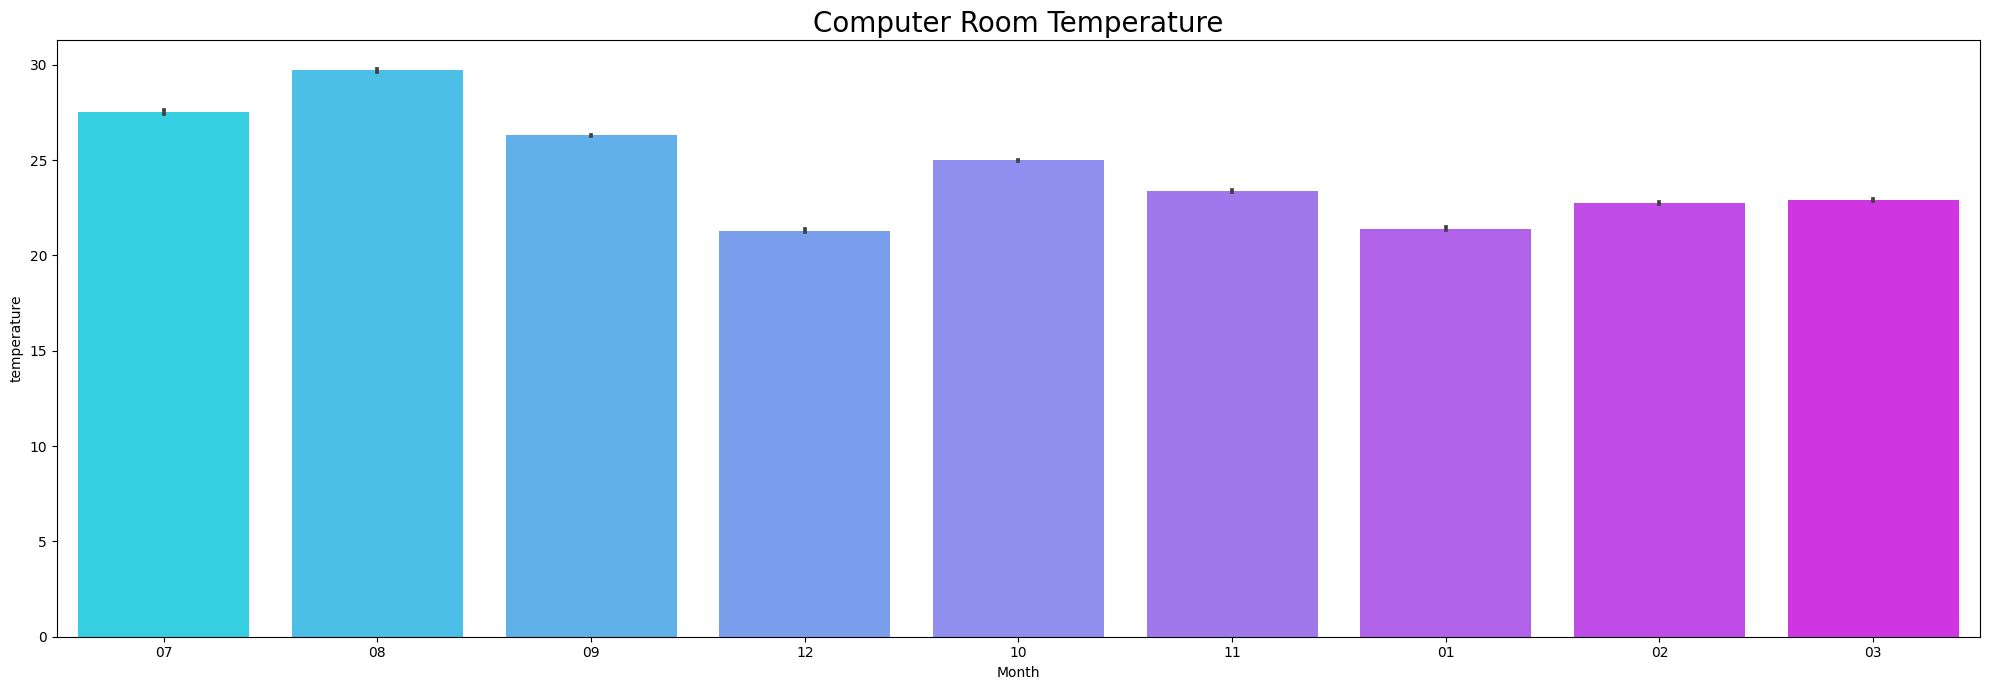

In [454]:
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['TM_outdoor'], "Computer Room TM Outdoor")
display_plot(Computer_Room_com, Computer_Room_com['Month'], Computer_Room_com['temperature'], "Computer Room Temperature")

In [455]:
# Test for normality, multimodality (Hartigan's Dip Test), and far outliers (Tukey's test)
table = TableOne(Computer_Room_com.drop(['Day', 'Month', 'Year','Hour', "Minutes", "o3"], axis = 1), dip_test=True, normal_test=True, tukey_test=True)
table

Missing        Overall
n                                             31489
Season, n (%)          0.0         0   11225 (35.6)
                       1.0              3355 (10.7)
                       2.0              5347 (17.0)
                       3.0             11562 (36.7)
Time_of_Day, n (%)     0.0         0    7940 (25.2)
                       1.0              5232 (16.6)
                       2.0              9196 (29.2)
                       3.0              9121 (29.0)
light_level, n (%)     0.0        14   23412 (74.4)
                       1.0              4313 (13.7)
                       2.0               1137 (3.6)
                       3.0                949 (3.0)
                       4.0               1664 (5.3)
co2, mean (SD)                     0   451.2 (90.4)
humidity, n (%)        22.0        0        1 (0.0)
                       22.5                 8 (0.0)
                       23.0                22 (0.1)
                       23.5                39 (0.1)
                       24.0                39 (0.1)
                       24.5                44 (0.1)
                       25.0                93 (0.3)
                       25.5               159 (0.5)
                       26.0               209 (0.7)
                       26.5               304 (1.0)
                       27.0               310 (1.0)
                       27.5               350 (1.1)
                       28.0               298 (0.9)
                       28.5               324 (1.0)
                       29.0               400 (1.3)
                       29.5               532 (1.7)
                       30.0               494 (1.6)
                       30.5               567 (1.8)
                       31.0               619 (2.0)
                       31.5               610 (1.9)
                       32.0               592 (1.9)
                       32.5               765 (2.4)
                       33.0               826 (2.6)
                       33.5               890 (2.8)
                       34.0               972 (3.1)
                       34.5               792 (2.5)
                       35.0               664 (2.1)
                       35.5               528 (1.7)
                       36.0               570 (1.8)
                       36.5               551 (1.7)
                       36.75                1 (0.0)
                       37.0               493 (1.6)
                       37.25                1 (0.0)
                       37.5               682 (2.2)
                       38.0               819 (2.6)
                       38.25                1 (0.0)
                       38.5               680 (2.2)
                       39.0               627 (2.0)
                       39.5               700 (2.2)
                       40.0               587 (1.9)
                       40.5               551 (1.7)
                       41.0               631 (2.0)
                       41.5               752 (2.4)
                       41.75                1 (0.0)
                       42.0               797 (2.5)
                       42.5               736 (2.3)
                       43.0               685 (2.2)
                       43.5               613 (1.9)
                       44.0               434 (1.4)
                       44.5               378 (1.2)
                       45.0               394 (1.3)
                       45.5               495 (1.6)
                       46.0               457 (1.5)
                       46.5               528 (1.7)
                       47.0               497 (1.6)
                       47.5               333 (1.1)
                       48.0               354 (1.1)
                       48.5               325 (1.0)
                       49.0               284 (0.9)
                       49.5               314 (1.0)
                       50.0               322 (1.0)
                       50

Tukey test indicates far outliers

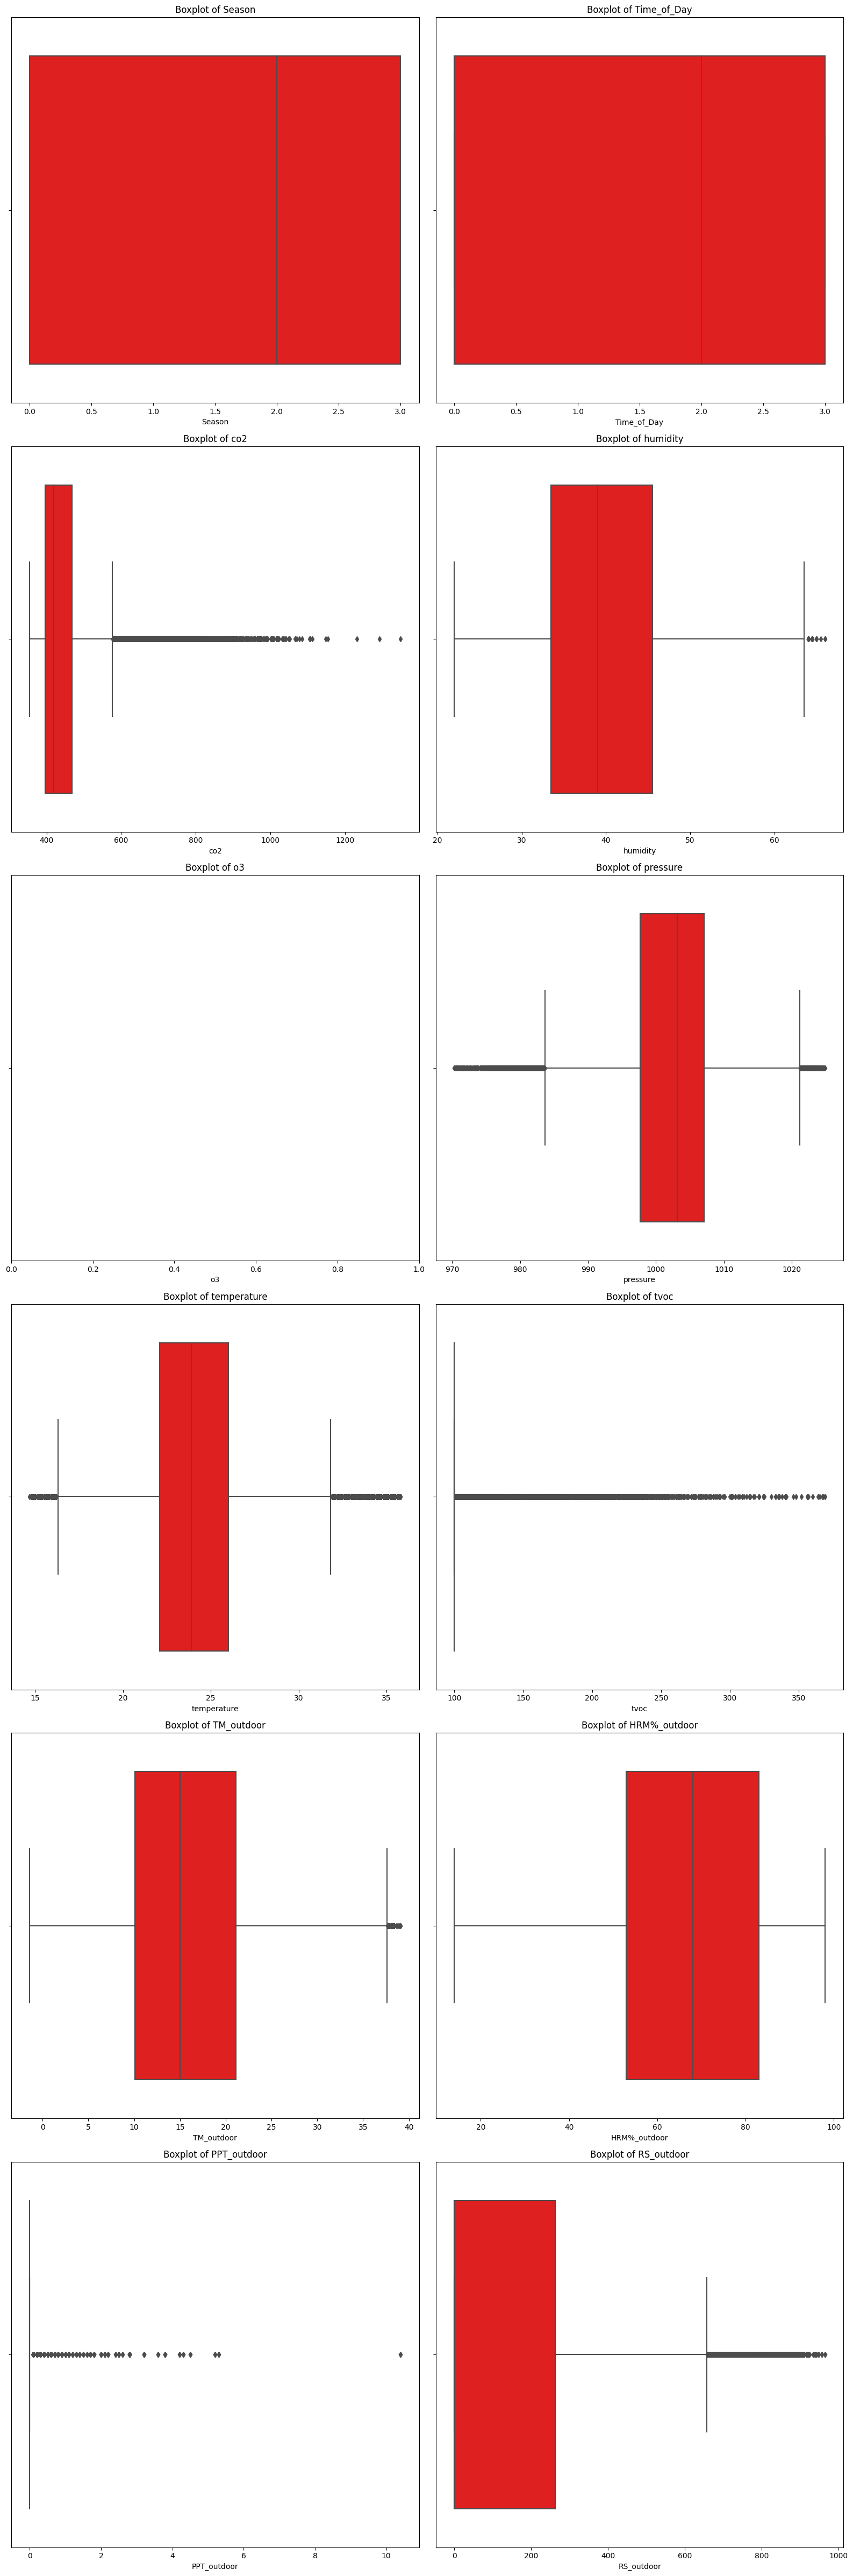

"Q1 = Computer_Room_com['co2'].quantile(0.25)\nQ3 = Computer_Room_com['co2'].quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\noutliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]\n\noutliers_co2"

In [461]:
display_outliers(Computer_Room_com)
"""Q1 = Computer_Room_com['co2'].quantile(0.25)
Q3 = Computer_Room_com['co2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_co2 = Computer_Room_com[(Computer_Room_com['co2'] < lower_bound) | (Computer_Room_com['co2'] > upper_bound)]

outliers_co2"""


Correlations

C:\Users\migue\AppData\Local\Temp\ipykernel_27644\3494042682.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)


<AxesSubplot:>

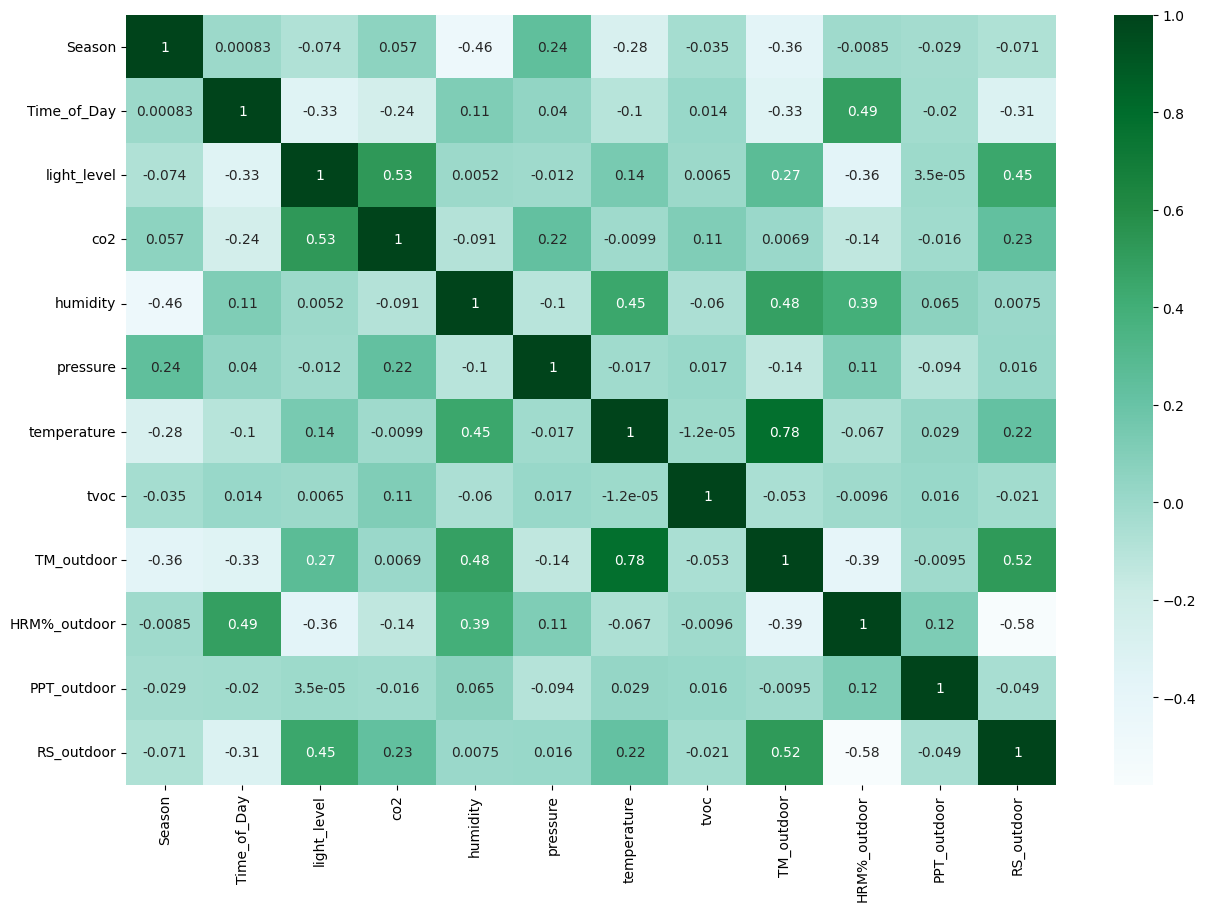

In [462]:
plt.figure(figsize=(15, 10))
sb.heatmap(Computer_Room_com.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)

It can be seen that the columns co2, pressure, tvoc do not have a correlation with any of the other variables. This is because they are totally independent and are not affected by the others.

Since, for example, the CO2 and TVOC columns are variables related to the air quality of the room itself.

In [537]:
Computer_Room_com

,Day,Month,Year,Season,Hour,Minutes,Time_of_Day,light_level,co2,humidity,o3,pressure,temperature,tvoc,TM_outdoor,HRM%_outdoor,PPT_outdoor,RS_outdoor
0,25,07,2023,2.0,13,50,0.0,1.0,431.0,37.0,NaN,997.6,27.4,100.0,31.0,25,0.0,808
1,25,07,2023,2.0,14,00,0.0,1.0,426.0,37.0,NaN,997.5,27.5,100.0,31.0,25,0.0,808
2,25,07,2023,2.0,14,10,0.0,1.0,438.0,37.0,NaN,997.6,27.5,100.0,31.0,25,0.0,808
3,25,07,2023,2.0,14,20,0.0,1.0,425.0,37.0,NaN,997.6,27.5,100.0,31.2,25,0.0,746
4,25,07,2023,2.0,14,30,0.0,1.0,442.0,36.5,NaN,997.5,27.6,100.0,31.2,25,0.0,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,03,2024,1.0,11,40,2.0,0.0,405.0,38.0,NaN,985.0,22.2,100.0,15.4,44,0.0,340
31485,30,03,2024,1.0,11,50,2.0,0.0,399.0,37.5,NaN,985.1,22.4,100.0,15.0,47,0.0,340
31486,30,03,2024,1.0,12,00,0.0,0.0,403.0,37.0,NaN,985.1,22.6,100.0,15.0,47,0.0,340
31487,30,03,2024,1.0,12,10,0.0,0.0,398.0,36.5,NaN,985.2,22.8,100.0,15.0,47,0.0,340


Bidirectional and Unidirectional LSTM

In [538]:
df_train=Computer_Room_com[['Day', "Hour","Minutes", 'Season',"Time_of_Day",'light_level','co2',"humidity",'tvoc','HRM%_outdoor', "PPT_outdoor", 'RS_outdoor', "TM_outdoor", "temperature"]]
print(len(df_train.columns))

14


In [539]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

light_level    14
dtype: int64


In [540]:
df_train = df_train.fillna(0)

In [541]:
print(df_train[df_train.columns[df_train.isnull().sum()>0]].isnull().sum())

Series([], dtype: float64)


In [542]:
df_train

,Day,Hour,Minutes,Season,Time_of_Day,light_level,co2,humidity,tvoc,HRM%_outdoor,PPT_outdoor,RS_outdoor,TM_outdoor,temperature
0,25,13,50,2.0,0.0,1.0,431.0,37.0,100.0,25,0.0,808,31.0,27.4
1,25,14,00,2.0,0.0,1.0,426.0,37.0,100.0,25,0.0,808,31.0,27.5
2,25,14,10,2.0,0.0,1.0,438.0,37.0,100.0,25,0.0,808,31.0,27.5
3,25,14,20,2.0,0.0,1.0,425.0,37.0,100.0,25,0.0,746,31.2,27.5
4,25,14,30,2.0,0.0,1.0,442.0,36.5,100.0,25,0.0,746,31.2,27.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31484,30,11,40,1.0,2.0,0.0,405.0,38.0,100.0,44,0.0,340,15.4,22.2
31485,30,11,50,1.0,2.0,0.0,399.0,37.5,100.0,47,0.0,340,15.0,22.4
31486,30,12,00,1.0,0.0,0.0,403.0,37.0,100.0,47,0.0,340,15.0,22.6
31487,30,12,10,1.0,0.0,0.0,398.0,36.5,100.0,47,0.0,340,15.0,22.8


In [543]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(df_train)
df_train_scaled =scaler.transform(df_train)
df_train_scaled.shape

(31489, 14)

In [544]:
lags=15
forecasts=8
X, y = [], []
for i in range(len(df_train_scaled) - forecasts-lags):
  X.append(df_train_scaled[i:(i + lags)])
  y.append(df_train_scaled[:,-1][i+lags: i+lags+ forecasts])
X,y =  np.array(X), np.array(y)
df_train_scaled.shape, X.shape, y.shape

((31489, 14), (31466, 15, 14), (31466, 8))

In [545]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((25172, 15, 14), (25172, 8), (6294, 15, 14), (6294, 8))

In [546]:
X_train, y_train, X_val, y_val

(array([[[ 1.49700532, -0.65181675,  0.29361855, ..., -0.56656404,
          -1.91685813, -2.49980786],
         [ 1.49700532, -0.65181675,  0.87964597, ..., -0.56656404,
          -1.91685813, -2.49980786],
         [ 1.49700532, -0.65181675,  1.46567339, ..., -0.34181239,
          -1.83767991, -2.49980786],
         ...,
         [ 1.49700532, -0.36215415,  0.29361855, ...,  0.6220264 ,
          -1.24384326, -2.49980786],
         [ 1.49700532, -0.36215415,  0.87964597, ...,  0.6220264 ,
          -1.24384326, -2.49980786],
         [ 1.49700532, -0.36215415,  1.46567339, ...,  0.82948946,
          -1.01950497, -2.49980786]],
 
        [[-0.48379056,  0.79649627,  1.46567339, ..., -0.65300698,
          -1.28343237, -0.3068229 ],
         [-0.48379056,  0.94132758, -1.4644637 , ..., -0.65300698,
          -1.28343237, -0.3068229 ],
         [-0.48379056,  0.94132758, -0.87843628, ..., -0.65300698,
          -1.28343237, -0.33606269],
         ...,
         [-0.48379056,  1.0861588

In [547]:
from tensorflow.keras.optimizers import Adam
class NNPredictionModel:
    def __init__(self, input_shape, output_units=8):
        self.model_1 = self.uni_LSTM(input_shape, output_units)
        self.model_2 = self.bi_LSTM(input_shape, output_units)

    def uni_LSTM(self, input_shape, output_units):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(64, activation='tanh', return_sequences=True),
            Dropout(0.2),
            LSTM(64, activation='tanh'),
            Dense(output_units, activation='linear')
        ])
        optimizer = Adam(learning_rate=0.0005)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def bi_LSTM(self, input_shape, output_units):
        model_bi = Sequential([
            Bidirectional(LSTM(256, return_sequences=True), input_shape= input_shape),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=True, activation = 'tanh')),
            Dense(20, activation='tanh'),
            Bidirectional(LSTM(128,return_sequences=False, activation = 'tanh')),
            Dense(20, activation='tanh'),
            tf.keras.layers.Dropout(0.20),
            Dense(output_units, activation = 'linear'),
        ])
        model_bi.compile(optimizer='adam', loss='mse')
        return model_bi

In [548]:
n_steps = X_train.shape[-2]
n_features =X_train.shape[-1]
input_shape=(n_steps, n_features)

model = NNPredictionModel(input_shape, output_units=8)
uni_model = model.model_1
bi_model = model.model_2

bi_model.summary()
tf.keras.utils.plot_model(bi_model)

uni_model.summary()
tf.keras.utils.plot_model(uni_model)

c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\migue\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_87                │ (None, 15, 512)        │       555,008 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 15, 20)         │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_88                │ (None, 15, 256)        │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 15, 20)         │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_89                │ (None, 256)            │       152,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 20)             │         5,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 8)              │           168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 880,868 (3.36 MB)

 Trainable params: 880,868 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_216 (LSTM)                 │ (None, 15, 128)        │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_217 (LSTM)                 │ (None, 15, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_218 (LSTM)                 │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,168 (610.03 KB)

 Trainable params: 156,168 (610.03 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Epoch 1/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - loss: 0.1514 - val_loss: 0.0177
Epoch 2/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.0371 - val_loss: 0.0168
Epoch 3/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - loss: 0.0295 - val_loss: 0.0148
Epoch 4/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0258 - val_loss: 0.0245
Epoch 5/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - loss: 0.0262 - val_loss: 0.0145
Epoch 6/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.0235 - val_loss: 0.0125
Epoch 7/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 0.0232 - val_loss: 0.0152
Epoch 8/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 0.0220 - val_loss: 0.0152
Epoch 9/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - loss: 0.0225 - val_loss: 0.0125
Epoch 10/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - loss: 0.0220 - val_loss: 0.0135
Epoch 11/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - loss: 0.0218 - val_loss: 0.0111
Epoch 12/100
779/77

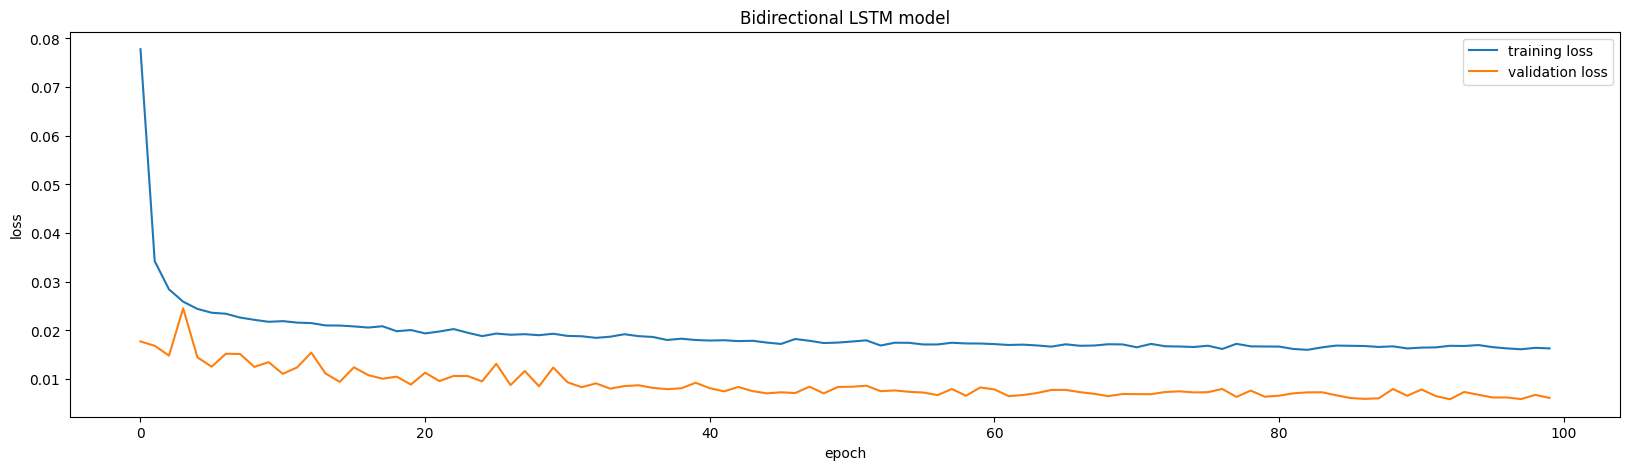

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Bidirectional LSTM model : 0.03533293631665537
Mean Squared Error(MSE) of Bidirectional LSTM model : 0.0038497515730479123
Root Mean Squared Error (RMSE) of Bidirectional LSTM model : 0.06176093330052504
Mean absolute percentage error (MAPE) of Bidirectional LSTM model : 0.13676725153210662
Explained Variance Score (EVS) of Bidirectional LSTM model : 0.9963283451961528
R2 of Bidirectional LSTM model : 1.0

 



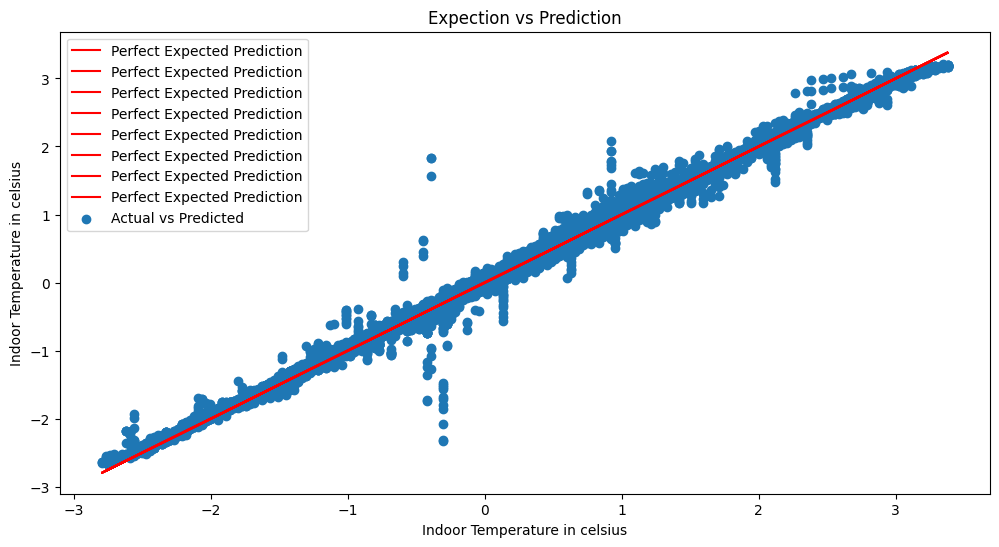

In [549]:
def model_train_evaluation(y, X, model, model_name):
    #Model run
    from tensorflow.keras.callbacks import EarlyStopping
    #early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    #history = model.fit(X_train,y_train, epochs=6,validation_data=(X_val, y_val),callbacks=early_stop)
    history = model.fit(X_train,y_train, epochs=100,validation_split=0.01)#, callbacks=early_stop)
    history_frame = pd.DataFrame(history.history)
    
    # model performance plot
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.title(model_name)
    plt.show()
    
    # Model Evaluation metrics
    from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score, mean_absolute_percentage_error
    ypred =model.predict(X)
    print("\n \n Model Evaluation Report: ")
    print('Mean Absolute Error(MAE) of', model_name,':', mean_absolute_error(y, ypred))
    print('Mean Squared Error(MSE) of', model_name,':', mean_squared_error(y, ypred))
    print('Root Mean Squared Error (RMSE) of', model_name,':', mean_squared_error(y, ypred, squared = False))
    print('Mean absolute percentage error (MAPE) of', model_name,':', mean_absolute_percentage_error(y, ypred))
    print('Explained Variance Score (EVS) of', model_name,':', explained_variance_score(y, ypred))
    print('R2 of', model_name,':', (r2_score(y, ypred)).round(2))
    print('\n \n')
    
    # Actual vs Predicted Plot
    f, ax = plt.subplots(figsize=(12,6),dpi=100);
    plt.scatter(y, ypred, label="Actual vs Predicted")
    # Perfect predictions
    plt.xlabel('Indoor Temperature in celsius')
    plt.ylabel('Indoor Temperature in celsius')
    plt.title('Expection vs Prediction')
    plt.plot(y,y,'r', label="Perfect Expected Prediction")
    plt.legend()


# Call the model_train_evaluation function
model_train_evaluation(y_val, X_val, bi_model, 'Bidirectional LSTM model')


Epoch 1/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.1443 - val_loss: 0.0212
Epoch 2/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0164 - val_loss: 0.0157
Epoch 3/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0142 - val_loss: 0.0141
Epoch 4/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0115 - val_loss: 0.0146
Epoch 5/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0108 - val_loss: 0.0125
Epoch 6/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0108 - val_loss: 0.0135
Epoch 7/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0095 - val_loss: 0.0107
Epoch 8/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0091 - val_loss: 0.0115
Epoch 9/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0092 - val_loss: 0.0104
Epoch 10/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0081 - val_loss: 0.0097
Epoch 11/100
779/779 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0078 - val_loss: 0.0098
Epoch 12/100
779/77

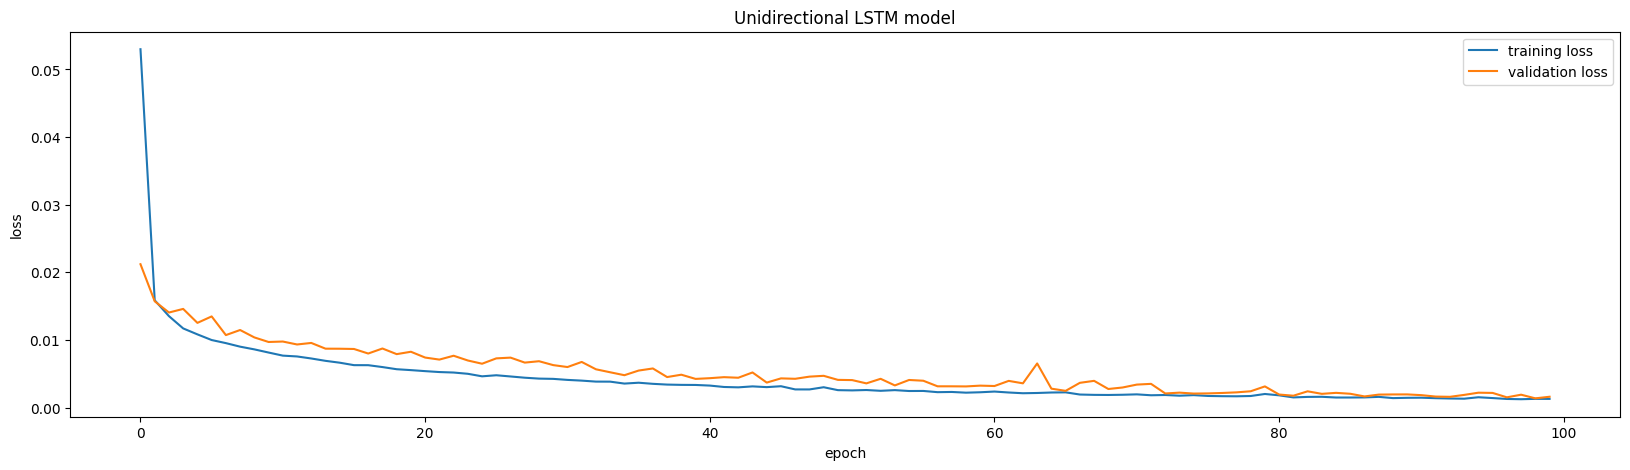

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

 
 Model Evaluation Report: 
Mean Absolute Error(MAE) of Unidirectional LSTM model : 0.024012653293537613
Mean Squared Error(MSE) of Unidirectional LSTM model : 0.002291427790115254
Root Mean Squared Error (RMSE) of Unidirectional LSTM model : 0.047421063846269575
Mean absolute percentage error (MAPE) of Unidirectional LSTM model : 0.10513189716051478
Explained Variance Score (EVS) of Unidirectional LSTM model : 0.9977817391856061
R2 of Unidirectional LSTM model : 1.0

 



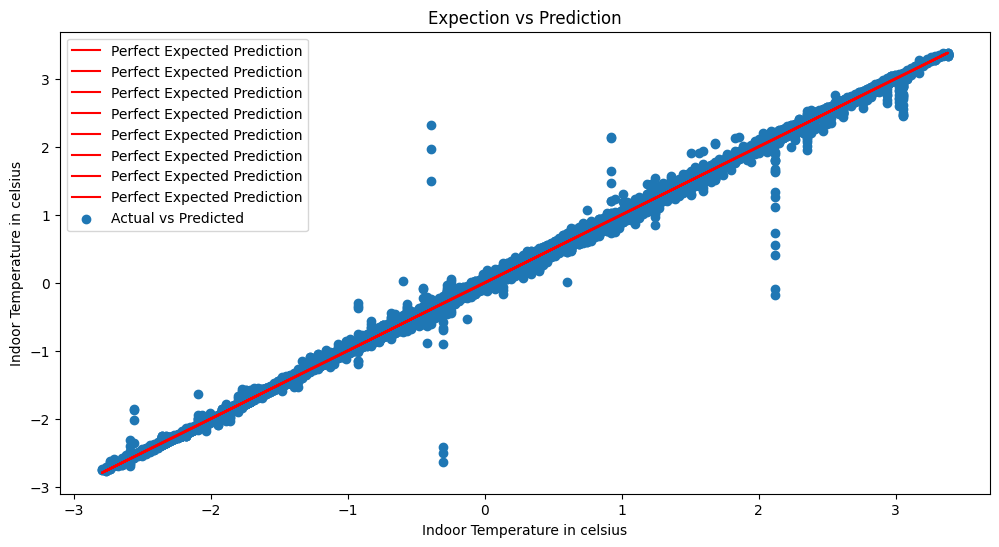

In [550]:
model_train_evaluation(y_val, X_val,uni_model, 'Unidirectional LSTM model')

In [565]:
import pandas as pd

data_test = {
    'Day': [9, 9, 9, 9, 9, 9, 9, 9, 9, 9],
    'Hour': [14, 14, 14, 14, 14, 14, 15, 15, 15, 15],
    'Minutes': [00, 10, 20, 30, 40, 50, 00, 10, 20, 30],
    'Season': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    'Time_of_Day': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    'light_level': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
}

df_new = pd.DataFrame(data_test)

In [566]:
df_test=df_new[['Day', "Hour", "Minutes", 'Season',"Time_of_Day","light_level"]]
df_test

,Day,Hour,Minutes,Season,Time_of_Day,light_level
0,9,14,0,1.0,0.0,1.0
1,9,14,10,1.0,0.0,1.0
2,9,14,20,1.0,0.0,1.0
3,9,14,30,1.0,0.0,1.0
4,9,14,40,1.0,0.0,1.0
5,9,14,50,1.0,0.0,1.0
6,9,15,0,1.0,0.0,1.0
7,9,15,10,1.0,0.0,1.0
8,9,15,20,1.0,0.0,1.0
9,9,15,30,1.0,0.0,1.0


In [567]:
train_test=df_train.append(df_test,ignore_index=True).fillna(0)
train_test

C:\Users\migue\AppData\Local\Temp\ipykernel_27644\237083430.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test=df_train.append(df_test,ignore_index=True).fillna(0)


,Day,Hour,Minutes,Season,Time_of_Day,light_level,co2,humidity,tvoc,HRM%_outdoor,PPT_outdoor,RS_outdoor,TM_outdoor,temperature
0,25,13,50,2.0,0.0,1.0,431.0,37.0,100.0,25.0,0.0,808.0,31.0,27.4
1,25,14,00,2.0,0.0,1.0,426.0,37.0,100.0,25.0,0.0,808.0,31.0,27.5
2,25,14,10,2.0,0.0,1.0,438.0,37.0,100.0,25.0,0.0,808.0,31.0,27.5
3,25,14,20,2.0,0.0,1.0,425.0,37.0,100.0,25.0,0.0,746.0,31.2,27.5
4,25,14,30,2.0,0.0,1.0,442.0,36.5,100.0,25.0,0.0,746.0,31.2,27.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31494,9,14,50,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31495,9,15,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31496,9,15,10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31497,9,15,20,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [568]:
def mean_std(train_test, column, position):
    # Obtener las últimas n columnas del DataFrame
    y_mean=train_test[column].mean()
    y_std=scaler.scale_[train_test.shape[1]-position]
    
    return y_mean, y_std

In [569]:
means = []
stds = []

for i, column in enumerate(train_test.columns[6:]):
    print(8 - i, column)
    y_mean, y_std = mean_std(train_test, column, 8-i)
    means.append(y_mean)
    stds.append(y_std)

print(means, stds)


8 co2
7 humidity
6 tvoc
5 HRM%_outdoor
4 PPT_outdoor
3 RS_outdoor
2 TM_outdoor
1 temperature
[451.0473189625067, 40.04262040064764, 106.75491285437633, 67.1492745801454, 0.017733896314168704, 151.03596939585384, 15.820622876916728, 24.241634655068413] [90.43537294780256, 8.517778146917959, 23.692091365349963, 18.07882987660605, 0.20823427559363905, 231.36649248794944, 7.577841481704633, 3.419996083263395]


In [570]:
def tests(column, y_std, y_mean):
    for i in range(len(df_train),len(train_test)):
        X_test=train_test[i-lags:i]
        X_test=scaler.transform(X_test)
        val=bi_model.predict(X_test.reshape(1,lags,X_test.shape[1]))
        val2=y_std*val[:,0]+y_mean
        train_test.loc[i,column,]=val2
        
    final_test1 = train_test[len(df_train):][[column]]


for i, column in enumerate(train_test.columns[6:]):
    tests(column, stds[i], means[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [571]:
train_test

,Day,Hour,Minutes,Season,Time_of_Day,light_level,co2,humidity,tvoc,HRM%_outdoor,PPT_outdoor,RS_outdoor,TM_outdoor,temperature
0,25,13,50,2.0,0.0,1.0,431.000000,37.000000,100.000000,25.000000,0.000000,808.000000,31.000000,27.400000
1,25,14,00,2.0,0.0,1.0,426.000000,37.000000,100.000000,25.000000,0.000000,808.000000,31.000000,27.500000
2,25,14,10,2.0,0.0,1.0,438.000000,37.000000,100.000000,25.000000,0.000000,808.000000,31.000000,27.500000
3,25,14,20,2.0,0.0,1.0,425.000000,37.000000,100.000000,25.000000,0.000000,746.000000,31.200000,27.500000
4,25,14,30,2.0,0.0,1.0,442.000000,36.500000,100.000000,25.000000,0.000000,746.000000,31.200000,27.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31494,9,14,50,1.0,0.0,1.0,215.317154,17.290226,43.047249,18.695614,-0.538374,-462.433899,-4.319480,22.854597
31495,9,15,0,1.0,0.0,1.0,221.930725,17.467058,43.859406,18.941143,-0.533708,-453.186035,-4.029021,23.074627
31496,9,15,10,1.0,0.0,1.0,234.595779,17.917360,45.307838,19.937290,-0.519826,-424.565308,-2.990230,23.073977
31497,9,15,20,1.0,0.0,1.0,244.281113,18.539618,46.555183,20.456985,-0.516383,-426.536621,-2.927741,23.025444
